In [2555]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

# O(n)
def bottomk_indices(v, k):
    return np.argpartition(v, k)[:k]

def not_indices(indices, shape):
    new_indices = np.ones(shape, dtype=bool)
    new_indices[indices] = False
    return new_indices

def normalize(x):
    min = np.min(x)
    return ((x - min) /
            (np.max(x) - min))

def clamp(x):
    return np.clip(x, 0, 1)

In [3733]:
raw_data_path = list(Path("../stimuli/obvious_gaussian_clusters").iterdir())[0]

In [3734]:
raw_data = np.load(raw_data_path)

## Structure of data

* x
* y
* cluster_number

In [3735]:
print("Shape: {}".format(raw_data.shape))
raw_data[:10]

Shape: (20, 3)


array([[346.93670781, 773.11255145,   0.        ],
       [359.13029152, 819.82879763,   0.        ],
       [336.35303862, 703.03756795,   0.        ],
       [382.0850861 , 672.65241735,   0.        ],
       [389.62233413, 744.58613532,   0.        ],
       [432.12742467,  82.18252923,   1.        ],
       [482.90067379,  31.5120241 ,   1.        ],
       [462.49873341,  25.6787751 ,   1.        ],
       [495.89468675,  83.64957469,   1.        ],
       [476.9516279 ,  62.23464235,   1.        ]])

In [3736]:
raw_points = raw_data[:, :2]

In [3737]:
# parameters
number_of_neurons_in_network = 100
bottomk_number = 10
learning_rate = 0.1
training_iterations = 100

In [3930]:
class Network:
    
    def __init__(self, D):
        # D are the values of the neurons
        self.D = D
        # W are the weights of the neurons
        self.W = np.ones(D.shape[0]) / 2
    
    @classmethod
    def generate_initial(cls, X):
        n_dims = X.shape[1]
        ranges = []
        for col_idx in range(n_dims):
            col_values = X[:, col_idx]
            min = np.min(col_values)
            max = np.max(col_values)
            ranges.append((min, max))

        final_transposed = []
        for min, max in ranges:
            final_transposed.append(np.random.uniform(min, max, number_of_neurons_in_network))

        return cls(np.array(final_transposed).T)
    
    def plot(self, X, edge=True):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], color="red")
        facecolors = np.array([0, 1, 0]) * np.ones(len(self.W)).reshape(len(self.W), 1).astype('int')
        facecolors = np.hstack((facecolors, self.W.reshape(-1, 1)))
        ax.scatter(self.D[:, 0], self.D[:, 1], facecolor=facecolors, edgecolor='b' if edge else None)
        return ax
    
    def __repr__(self):
        return f"<Network D={len(self.D)}>"


<AxesSubplot:>

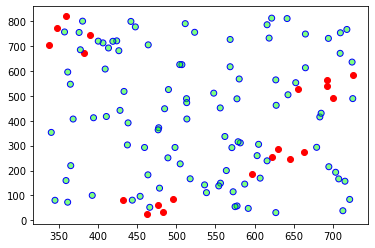

In [3931]:
network = Network.generate_initial(raw_points)
network.plot(raw_points)

0.9585184591844074


<AxesSubplot:>

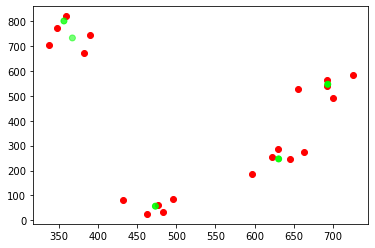

In [3952]:
# experimental training loop
shape = raw_points.shape

 # inhibition amount
activation_in_network = np.sum(network.W) / network.W.shape[0]
inhibition_ratio  = 1 - activation_in_network

# data point similarity
for data_point in raw_points:
    difference_vectors =  network.D - data_point.reshape(1, shape[1])
    euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
    nearby_indices = bottomk_indices(euclidean_distances, bottomk_number)
    close_neurons_distances = euclidean_distances[nearby_indices]
    
    # hebbian part, move them closer, this is very important
    network.D[nearby_indices] = network.D[nearby_indices] - learning_rate * network.W[nearby_indices].reshape(-1, 1) * difference_vectors[nearby_indices]
    
    # reduce weights of far away points, this seems fairly important to kill neurons that are not doing anything
    weight_change_reduction_indices = not_indices(nearby_indices, network.W.shape)
    network.W[weight_change_reduction_indices] = clamp(network.W[weight_change_reduction_indices] - 0.01)

    # increase weight of the closest point
    #i = np.argmin(euclidean_distances)
    #network.W[i] = clamp(network.W[i] + 0.2)
    network.W[nearby_indices] = clamp(network.W[nearby_indices] + network.W[nearby_indices] * 0.5)
    

    
    # tan(x) based inhibition
    #normalized_neuron_distances = normalize(close_neurons_distances)
#     weight_changes = np.tan(normalized_neuron_distances - 0.5) * network.W[nearby_indices]
#     print(weight_changes)
#     network.W[nearby_indices] = clamp(network.W[nearby_indices] + weight_changes)
    
# neuron proximity based inhibition
for idx in range(0, len(network.D)):
    neuron = network.D[idx]
    neuron_weight = network.W[idx]
    difference_vectors_from_other_neurons = network.D - neuron.reshape(1, shape[1])
    euclidean_distances = np.linalg.norm(difference_vectors_from_other_neurons, ord=2, axis=1)
    # plus one because the neuron itself is in the dataset
    near_neuron_indices = bottomk_indices(euclidean_distances, bottomk_number + 1)
    weight_change_neuron_indicies = near_neuron_indices[near_neuron_indices != idx]
    normalized_distances = normalize(euclidean_distances[weight_change_neuron_indicies])
    weight_changes = (1 - normalized_distances) * neuron_weight
    network.W[weight_change_neuron_indicies] = clamp(network.W[weight_change_neuron_indicies] - weight_changes)
        
  
    
    # reduce weights of nearby points
    # network.W[nearby_indices] = clamp(network.W[nearby_indices] - (0.01 * inhibition_ratio), 0, 1)
    

print(inhibition_ratio)
network.plot(raw_points, edge=False)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([0.85 , 0.865, 0.88 , 0.895, 0.91 , 0.925, 0.94 , 0.955, 0.97 ,
        0.985, 1.   ]),
 <BarContainer object of 10 artists>)

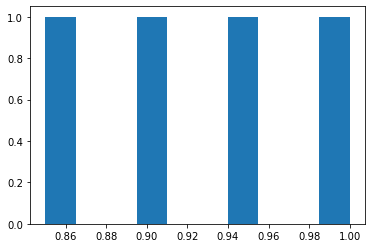

In [3822]:
plt.hist(network.W[network.W != 0])

<AxesSubplot:>

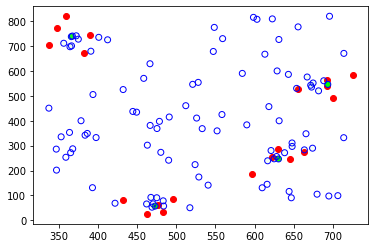

In [3818]:
# simple training loop
shape = raw_points.shape
for data_point in raw_points:
    difference_vectors =  network.D - data_point.reshape(1, shape[1])
    euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
    nearby_indices = bottomk_indices(euclidean_distances, bottomk_number)
    close_neurons_distances = euclidean_distances[nearby_indices]
    closest_value_index = np.argmax(close_neurons_distances)
    network.D[nearby_indices] = network.D[nearby_indices] - learning_rate * difference_vectors[nearby_indices]
    
    # reduce weights of far away points
    weight_change_reduction_indices = not_indices(nearby_indices, network.W.shape)
    network.W[weight_change_reduction_indices] = np.clip(network.W[weight_change_reduction_indices] - 0.001, 0, 1)

    # increase weights of nearby points
    network.W[nearby_indices] = np.clip(network.W[nearby_indices] + 0.010, 0, 1)

network.plot(raw_points)


<AxesSubplot:>

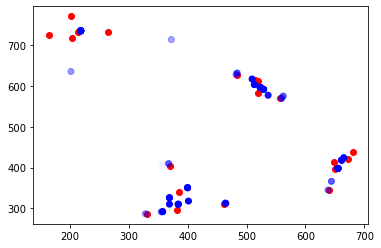

In [1614]:
# sampling training loop

shape = raw_points.shape
num_in_sample = shape[0] // 3
for _ in range(training_iterations):
  sample = raw_points[np.random.choice(np.arange(shape[0]), num_in_sample)]
  for data_point in sample:
      difference_vectors =  network.D - data_point.reshape(1, shape[1])
      euclidean_distances = np.linalg.norm(difference_vectors, ord=2, axis=1)
      nearby_indices = bottomk_indices(euclidean_distances, bottomk_number)
      close_neurons_distances = euclidean_distances[nearby_indices]
      closest_value_index = np.argmax(close_neurons_distances)
      network.D[nearby_indices] = network.D[nearby_indices] - learning_rate * difference_vectors[nearby_indices]
      
      # reduce weights of far away points
      weight_change_reduction_indices = not_indices(nearby_indices, network.W.shape)
      network.W[weight_change_reduction_indices] = np.clip(network.W[weight_change_reduction_indices] - 0.001, 0, 1)

      # increase weights of nearby points
      network.W[nearby_indices] = np.clip(network.W[nearby_indices] + 0.010, 0, 1)

network.plot(raw_points)


In [3161]:
np.array([[1, 2, 3]]) * np.ones(100).reshape(100, 1).astype('int')

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1,